# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.backends.backend_pdf import PdfPages
np.seterr(all='warn')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# Plotting options
plt.rc('axes', labelsize=16)  
plt.rc('axes', titlesize=16)  
plt.rc('legend', fontsize=14)  

# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']
# default_cycler = cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors))
# plt.rc('axes', prop_cycle=default_cycler)

# Equation

## Regulators

Viscosity : $r(y) = \frac{1}{e^{y^2}-1}$ , $r^\prime(y) = \frac{-2 y e^{y^2}}{r(y)^2}$

Forcing : $n(y) = y^2 e^{-y^2}$ , $n^\prime(y) = -2 y e^{-y^2} (y^2 - 1) $

In [3]:
def r(y) :
    if (y>10):
        return 0.
    elif (y<1e-5) :
        return y**(-2)
    else :
        return 1./(np.exp(y*y)-1.)
def rprime(y) :
    if (y>10):
        return 0.
    elif (y<1e-5) :
        return -2*y**(-3)
    else :
        return -2.*np.exp(y*y)*y*(r(y)**2)

In [4]:
def n(y) : 
    if (y>10):
        return 0.
    else :
        return y*y*np.exp(-y*y)
def nprime(y) :
    if (y>10):
        return 0.
    else :
        return -2.*np.exp(-y*y)*y*(-1.+y*y)

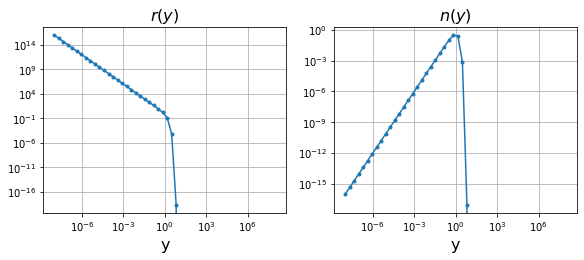

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(8,3.5))
x = np.logspace(-8, 8, 50)
ax[0].loglog(x, [r(val) for val in x], '.-')
ax[1].loglog(x, [n(val) for val in x], '.-')
for axis in ax : axis.set(xlabel='y'), axis.grid()
ax[0].set(title=r'$r(y)$')
ax[1].set(title=r'$n(y)$')
plt.show()

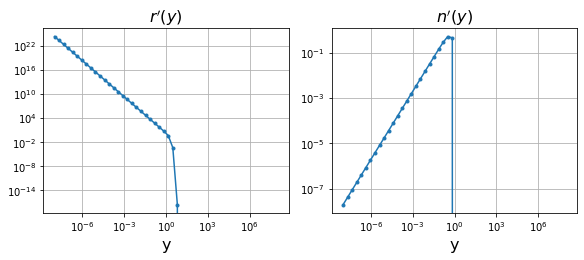

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(8,3.5))
x = np.logspace(-8, 8, 50)
ax[0].loglog(x, [-rprime(val) for val in x], '.-')
ax[1].loglog(x, [nprime(val) for val in x], '.-')
for axis in ax : axis.set(xlabel='y'), axis.grid()
ax[0].set(title=r'$r^\prime(y)$')
ax[1].set(title=r'$n^\prime(y)$')
plt.show()

## Flow

In [7]:
def Fv(kappa,km) :
    return (nu_L + D0*(L**eps-kappa**eps)*(1./((L**eps+(km/lmbda)**eps)*(kappa**eps+(km/lmbda)**eps)) + (lmbda**2)/((kappa**eps+km**eps)*(L**eps+km**eps)) ))
def dsFv(kappa,km) :
    return -(eps*(kappa**eps)*D0*(1./((km/lmbda)**eps+kappa**eps)**2) + lmbda**2/((km**eps+kappa**eps)**2))  

In [8]:
def dsR(km, kappa) :
    return -nu_L*(km**3)/kappa*rprime(km/kappa)
def dsN(km, kappa) :
    return -D_L*km/kappa*nprime(km/kappa)
def dsRv(km, kappa) : 
    return eps*(kappa**(eps))/D0
def rho(km, kappa) :
    return (km**2)*(Fv(kappa,km)+nu_L*r(km/kappa))
#def delta(m, kappa, fd) :
#    return D_L*(n(k[m]/kappa)+fd(kappa))
def U(km, kappa) :
    return 2.*D0/(kappa**eps+km**eps)

In [9]:
def derivative_Fv(s, Fv_num) :
    kappa = L*np.exp(s)
    return -(eps*(kappa**eps)*D0)*(1./((k/lmbda)**eps+kappa**eps)**2 + lmbda**2/(k**eps+kappa**eps)**2 ) 

In [10]:
def derivative_fd(s, fd) :
    kappa = L*np.exp(s)
    N = len(indices_m)
    result=np.zeros(N)
    # extrapolation for boundary points
#     fit1 = np.polyfit(k[0:3], fd[0:3], 2)
#     fd_begin = np.polyval(fit1,k[0]/lmbda) # parabolic extrapolation
#     fit2 = np.polyfit(np.log(k[-4:]), np.log(np.abs(fd[-4:])), 1) 
#     fd_end = np.exp(np.polyval(fit2,np.log(k[-1]*lmbda))) # power law extrapolation
    fd_begin = 0.0
    fd_end = 0.0
    extrapol_fd = np.insert(fd,[0,-1],[fd_begin,fd_end])
    for i in range(N) :
        i_fd = i+1
#         result[i] = -0.25/D_L* \
#         (k[i]**2*U(k[i]/lmbda, kappa)/(rho(k[i]/lmbda,kappa)**2)*((D_L*(n(k[i]/lmbda/kappa)+extrapol_fd[i_fd-1]))*\
#                                                                (2.*dsR(k[i]/lmbda, kappa) + rho(k[i]/lmbda, kappa)*U(k[i]/lmbda, kappa)*dsRv(k[i]/lmbda,kappa)) -\
#                                                               -2.*dsN(k[i]/lmbda,kappa)*rho(k[i]/lmbda,kappa)) + \
#         (k[i]*lmbda)**2*U(k[i], kappa)/(rho(k[i]*lmbda,kappa)**2)*((D_L*(n(k[i]*lmbda/kappa)+extrapol_fd[i_fd+1]))*\
#                                                                (2.*dsR(k[i]*lmbda, kappa) + rho(k[i]*lmbda, kappa)*U(k[i], kappa)*dsRv(k[i],kappa)) -\
#                                                               -2.*dsN(k[i]*lmbda,kappa)*rho(k[i]*lmbda,kappa)) )
        result[i] = -0.25/D_f(k[i])* \
        (k[i]**2*U(k[i]/lmbda, kappa)/(rho(k[i]/lmbda,kappa)**2)*((D_f(k[i]/lmbda)*(n(k[i]/lmbda/kappa)+extrapol_fd[i_fd-1]))*\
                                                               (2.*dsR(k[i]/lmbda, kappa) + rho(k[i]/lmbda, kappa)*U(k[i]/lmbda, kappa)*dsRv(k[i]/lmbda,kappa)) -\
                                                              -2.*dsN(k[i]/lmbda,kappa)*rho(k[i]/lmbda,kappa)) + \
        (k[i]*lmbda)**2*U(k[i], kappa)/(rho(k[i]*lmbda,kappa)**2)*((D_f(k[i]*lmbda)*(n(k[i]*lmbda/kappa)+extrapol_fd[i_fd+1]))*\
                                                               (2.*dsR(k[i]*lmbda, kappa) + rho(k[i]*lmbda, kappa)*U(k[i], kappa)*dsRv(k[i],kappa)) -\
                                                              -2.*dsN(k[i]*lmbda,kappa)*rho(k[i]*lmbda,kappa)) )
    return result

# Constants

In [11]:
nu_L = 1.0 #viscosity
D0 = 1.0 # velocity variance
eps = 1.5
k0 = 0.01
L = 10**8
D_L = 1.0 # forcing power
def D_f(k) : 
    return np.full_like(k, D_L)
#     amplitude = 10e8
#     peak_k=1e-10
#     return amplitude/(1.+(k/peak_k))**4

In [12]:
Nshells = 100
lmbda = 2.0

In [13]:
# x=np.logspace(-2,3,Nshells)
# print(x)

In [14]:
# x[2]/x[1]

In [15]:
k = np.zeros(Nshells, dtype=np.double)
shift = 70
indices_m = np.arange(-shift,Nshells-shift)
k = k0*lmbda**indices_m
print(k)

[8.47032947e-24 1.69406589e-23 3.38813179e-23 6.77626358e-23
 1.35525272e-22 2.71050543e-22 5.42101086e-22 1.08420217e-21
 2.16840434e-21 4.33680869e-21 8.67361738e-21 1.73472348e-20
 3.46944695e-20 6.93889390e-20 1.38777878e-19 2.77555756e-19
 5.55111512e-19 1.11022302e-18 2.22044605e-18 4.44089210e-18
 8.88178420e-18 1.77635684e-17 3.55271368e-17 7.10542736e-17
 1.42108547e-16 2.84217094e-16 5.68434189e-16 1.13686838e-15
 2.27373675e-15 4.54747351e-15 9.09494702e-15 1.81898940e-14
 3.63797881e-14 7.27595761e-14 1.45519152e-13 2.91038305e-13
 5.82076609e-13 1.16415322e-12 2.32830644e-12 4.65661287e-12
 9.31322575e-12 1.86264515e-11 3.72529030e-11 7.45058060e-11
 1.49011612e-10 2.98023224e-10 5.96046448e-10 1.19209290e-09
 2.38418579e-09 4.76837158e-09 9.53674316e-09 1.90734863e-08
 3.81469727e-08 7.62939453e-08 1.52587891e-07 3.05175781e-07
 6.10351563e-07 1.22070313e-06 2.44140625e-06 4.88281250e-06
 9.76562500e-06 1.95312500e-05 3.90625000e-05 7.81250000e-05
 1.56250000e-04 3.125000

In [16]:
indices_m

array([-70, -69, -68, -67, -66, -65, -64, -63, -62, -61, -60, -59, -58,
       -57, -56, -55, -54, -53, -52, -51, -50, -49, -48, -47, -46, -45,
       -44, -43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33, -32,
       -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19,
       -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,
        -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,
         8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29])

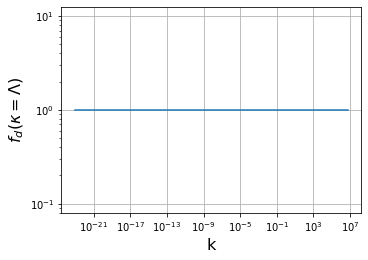

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))
ax.plot(k, D_f(k),  '-')
ax.set(xscale='log', yscale='log', xlabel='k', ylabel=r'$f_d(\kappa=\Lambda)$');ax.grid()
plt.show()

# Scale discretization and initial conditions

In [18]:
s_begin = 0.
s_end = -100.0
ds = 1e-2
nb_iter = -int(s_end/ds)
s = np.linspace(s_begin,s_end,nb_iter, dtype=np.double)

In [19]:
solution_fd = np.zeros([Nshells, len(s)], dtype=np.double)
solution_fv = np.zeros([Nshells, len(s)], dtype=np.double)

In [20]:
kappa_vec = L*np.exp(s)
print(kappa_vec[0],kappa_vec[-1])

100000000.0 3.720075976020836e-36


In [21]:
smallness_eps = 10e-4

In [22]:
solution_fv[:,0] = nu_L

In [23]:
# solution_fd[:,0] = smallness_eps/(1+(k/k0))**4

# fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))
# f1 = np.polyfit(k[1:4], solution_fd[1:4,0], 2)
# f2 = np.polyfit(np.log(k[-4:-1]), np.log(solution_fd[-4:-1,0]), 1)
# ax.plot(k, solution_fd[:,0],  '.-')
# ax.plot(k[0], np.polyval(f1,k[0]),  'o')
# ax.plot(k[-1], np.exp(np.polyval(f2,np.log(k[-1]))), 'o')
# ax.set(title=r'Init. condition $\kappa=\Lambda$', xscale='log', yscale='log', xlabel='k', ylabel=r'$f_d(\kappa=\Lambda)$');ax.grid()
# plt.show()

# Solution

In [24]:
# solution_ivp_fv = solve_ivp(derivative_Fv, [s_begin,s_end], np.full_like(k, 10), method='RK45', t_eval=s, max_step=0.000001)
# solution_fv = solution_ivp_fv.y
# x = solution_ivp_fv.t

In [25]:
# for i in range(nb_iter-1):
#     # RK2
#     solution_inter=solution_fv[:,i]-0.5*ds*derivative_Fv(s[i], solution_fv[:,i])
#     solution_fv[:,i+1]=solution_fv[:,i]-ds*derivative_Fv(s[i]-0.5*ds, solution_inter)

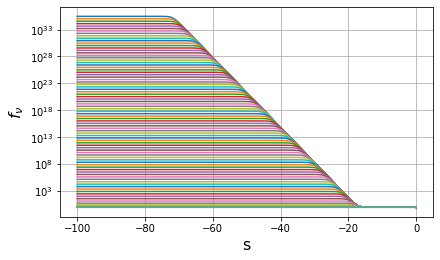

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(6,3.5))
for i in range(len(k)) :   
    #ax.plot(s, solution_fv[i,:], '--')
    ax.plot(s, Fv(kappa_vec,k[i]), label='%2.0f' % indices_m[i])
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
ax.set(xlabel='s', ylabel=r'$f_\nu$', yscale='log'); ax.grid()
plt.show()

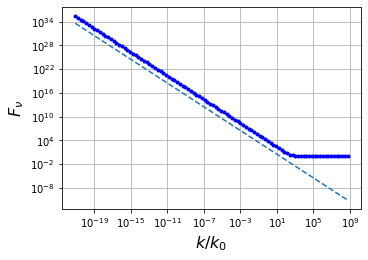

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))

# for m in range(len(k)) :   
#     ax.plot(np.full_like(solution_fv[m,:], k[m]),solution_fv[m,:], '-', label='%2.0f' % m)
#ax.plot(k, Fv(kappa_vec[0],k), 'ro-')
ax.plot(k/k0, Fv(kappa_vec[-1],k)*k**0, 'b.-')
ax.plot(k/k0, 10e-2*k**(-eps), '--')
#ax.plot(k, 10e-0*k**(-2*eps), '--')
#ax.plot(k/k0,np.full_like(k, nu_L), 'k-',lw=3)
#ax.plot(k,solution_fv[:,-1], 'k.-')
#ax.legend()
ax.set(xlabel=r'$k/k_0$', ylabel=r'$F_\nu$', yscale='log', xscale='log'); ax.grid()
plt.show()

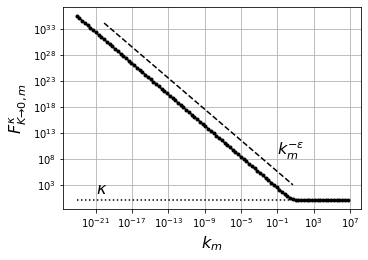

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))

# for i in range(len(k)) :   
#     ax.plot(np.full_like(kappa_vec[:], k[i]/k0),Fv(kappa_vec,k[i]), '-', label='%2.0f' % indices_m[i], color='silver')
#ax.plot(k,Fv(kappa_vec[0],k), 'k-')
ax.plot(k,Fv(kappa_vec[-1],k), 'k.-')
ax.plot(k[10:-20], 10e3*k[10:-20:]**(-eps), 'k--')
ax.plot(k, np.full_like(k, nu_L), 'k:')
ax.annotate(r'$k_m^{-\varepsilon}}$', xy=(0.1, 5e8), size='16')
ax.annotate(r'$\kappa$', xy=(10e-22, 20), size='16')
#ax.legend()
ax.set(xlabel=r'$k_m$', ylabel=r'$F^{\kappa}_{K \to 0, m}$', yscale='log', xscale='log'); ax.grid()
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these_overleaf/60ed6b1cd4de842e8afa5cb1/Figures/solution_Fkappa.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

In [29]:
# for i in range(nb_iter-1):
#     # RK2
#     solution_inter=solution_fd[:,i]-0.5*ds*derivative_fd(s[i], solution_fd[:,i])
#     solution_fd[:,i+1]=solution_fd[:,i]-ds*derivative_fd(s[i]-0.5*ds, solution_inter)
#     # RK4
# #     k1 = derivative_fd(s[i], solution_fd[:,i])
# #     k2 = derivative_fd(s[i]-0.5*ds, solution_fd[:,i]-0.5*ds*k1)
# #     k3 = derivative_fd(s[i]-0.5*ds, solution_fd[:,i]-0.5*ds*k2)
# #     k4 = derivative_fd(s[i]-ds, solution_fd[:,i]-ds*k3)
# #     solution_fd[:,i+1]=solution_fd[:,i]-ds/6.*(k1+k2+k3+k4)

In [30]:
# fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))
# for i in np.arange(Nshells) :
#     sl=np.s_[:]
#     ax.plot(s[sl], solution_fd[i,sl], label='%2.0f' % i)
# #ax.plot(s, solution_fd[-1,:], label='%2.0f' % i)
# #ax.legend()
# #ax.legend()
# ax.set(xlabel='s', ylabel=r'$f_d$', yscale="symlog"); ax.grid()
# plt.show()

In [31]:
# fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))

# for i in range(len(k)) :   
#     ax.plot(np.full_like(solution_fd[i,:], k[i]),solution_fd[i,:], '.-', label='%2.0f' % indices_m[i])
# ax.plot(k,solution_fd[:,0])
# ax.plot(k,solution_fd[:,-1])
# #ax.legend()
# ax.set(xlabel='k', ylabel=r'$f_d$', yscale='symlog', xscale='log'); ax.grid()
# plt.show()

In [32]:
# fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))

# ax.plot(k,solution_fd[:,-1], '.-')
# #ax.legend()
# ax.set(xlabel='k', ylabel=r'$f_d$', yscale='log', xscale='log'); ax.grid()
# plt.show()

In [33]:
#smallness_eps = 10e-10
#solution_ivp_fd = solve_ivp(derivative_fd, [s_begin,s_end], smallness_eps/(1+k)**4, method='RK45', max_step=10*ds)
solution_ivp_fd = solve_ivp(derivative_fd, [s_begin,s_end], np.zeros(len(k)), method='RK45', max_step=10*ds)
solution_fd = solution_ivp_fd.y
x = solution_ivp_fd.t

/home/gorbunov8a/.local/lib/python3.6/site-packages/scipy/integrate/_ivp/rk.py:119: RuntimeWarning: underflow encountered in nextafter
  min_step = 10 * np.abs(np.nextafter(t, self.direction * np.inf) - t)


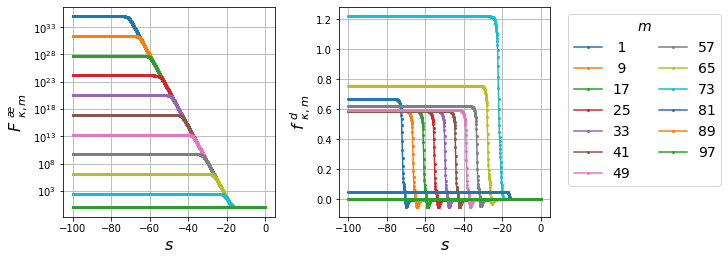

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(10,3.5))
for m in np.arange(1,Nshells,8):   
    ax[0].plot(s,Fv(kappa_vec,k[m]), '.-', ms=4)
    ax[1].plot(solution_ivp_fd.t,solution_fd[m,:], '.-', label='%2.0f' % m, ms=4)
    
ax[0].set(xlabel=r'$s$', ylabel=r'${F~}^{\ae}_{\kappa,m}$', yscale='log'); ax[0].grid()
ax[1].legend(title=r'$m$', title_fontsize=14, ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].set(xlabel=r'$s$', ylabel=r'${f~}^d_{\kappa,m}$', yscale='linear'); ax[1].grid()
#plt.savefig("/home/gorbunov8a/Documents/Latex/these_overleaf/60ed6b1cd4de842e8afa5cb1/Figures/solution_Fd_flow.png", dpi=150, format="png")
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these_overleaf/60ed6b1cd4de842e8afa5cb1/Figures/solution_Fd_flow.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

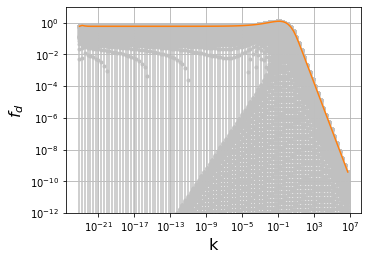

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))

for i in range(len(k)) :   
    ax.plot(np.full_like(solution_fd[i,:], k[i]),solution_fd[i,:], '.-', label='%2.0f' % indices_m[i], color='silver')
ax.plot(k,solution_fd[:,0])
ax.plot(k,solution_fd[:,-1])
#ax.legend()
ax.set(xlabel='k', ylabel=r'$f_d$', yscale='log', xscale='log'); ax.grid()
ax.set(ylim=[1e-12,1e1])
plt.show()

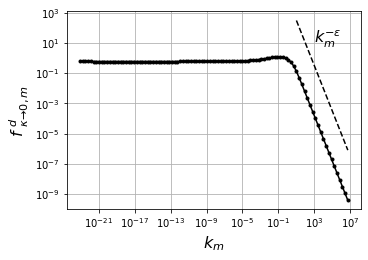

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3.5))

ax.plot(k,solution_fd[:,-1], 'k.-')
ax.plot(k[-20::], 10e3*k[-20::]**(-eps), 'k--')
#ax.plot(k, np.full_like(k, 1.0), 'k--')
ax.annotate(r'$k_m^{-\varepsilon}}$', xy=(1e3, 1e1), size='16')
ax.set(xlabel=r'$k_m$', ylabel=r'${f~}^d_{\kappa \to 0, m}$', yscale='log', xscale='log'); ax.grid()
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these_overleaf/60ed6b1cd4de842e8afa5cb1/Figures/solution_Fd.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

# Structure function S2

In [37]:
s_indices = np.arange(len(x))[::10]
print(s_indices)

[   0   10   20   30   40   50   60   70   80   90  100  110  120  130
  140  150  160  170  180  190  200  210  220  230  240  250  260  270
  280  290  300  310  320  330  340  350  360  370  380  390  400  410
  420  430  440  450  460  470  480  490  500  510  520  530  540  550
  560  570  580  590  600  610  620  630  640  650  660  670  680  690
  700  710  720  730  740  750  760  770  780  790  800  810  820  830
  840  850  860  870  880  890  900  910  920  930  940  950  960  970
  980  990 1000]


In [38]:
S2_evolve = np.zeros([Nshells,len(s_indices)])
for i in range(Nshells) : 
    for index, i_s in enumerate(s_indices) :
        curr_kappa = L*np.exp(x[i_s])
        S2_evolve[i,index] = 0.25*(D_L*(n(k[i]/curr_kappa)+solution_fd[i,i_s]))/rho(k[i], curr_kappa)

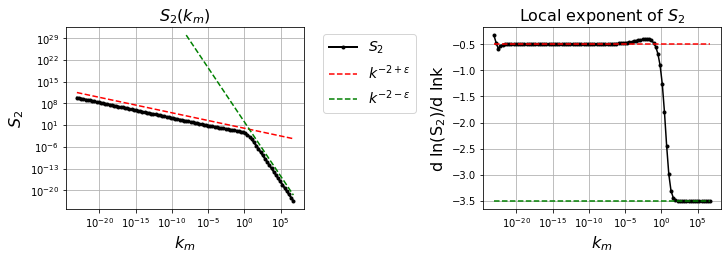

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(10,3.5))
#fig.suptitle(r'$\epsilon$ = %2.1f, $\nu_L$ = %2.2g, $D^v_0$ = %2.2g, $D^f_\lambda$ = %2.2g, $N$ = %2.0i, $\lambda$ = %2.2g, $k_0$= %2.1g, $\Lambda$ = %2.2e'%(eps, nu_L, D0, D_L, Nshells, lmbda, k0, L), fontsize=16)
# for m in range(Nshells) :
#     ax[0].plot(np.full_like(S2_evolve[m,:], k[m]), S2_evolve[m,:], '.--', color='silver')
ax[0].plot(k,S2_evolve[:,-1], 'k.-', lw=2, label=r'$S_2$')
#ax[0].plot(k,S2_evolve[:,0], '.--', label=r'$S_2 (\kappa = \Lambda$)')
ax[0].plot(k,10e-1*k**(-2+eps), '--',label=r'$k^{-2+\epsilon}$', color='red')
#ax[0].plot(k,10e-3*k**(-2), '--',label=r'$k^{-2}$')
ax[0].plot(k[len(k)//2::],10e1*k[len(k)//2::]**(-2-eps), '--',label=r'$k^{-2-\epsilon}$', color='green')
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set(title=r'$S_2(k_m)$', xscale='log', yscale='log', xlabel=r'$k_m$', ylabel=r'$S_2$'); ax[0].grid(True)

slope = np.gradient(np.log(S2_evolve[:,-1]), np.log(k))
ax[1].plot(k, slope, 'k.-', label='loc. exponent')
ax[1].plot(k, np.full_like(k, -2+eps), '--', label=r'$-2+\epsilon$', color='red')
ax[1].plot(k, np.full_like(k, -2-eps), '--', label=r'$-2-\epsilon$', color='green')
ax[1].set(title=r'Local exponent of $S_2$' ,xscale='log', yscale='linear', xlabel=r'$k_m$', ylabel=r'$\rm{d}~\ln(S_2)/\rm{d}~\ln k$'); ax[1].grid(True)
#ax[1].set(ylim=[-4,1])
#ax[1].legend()

# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these_overleaf/60ed6b1cd4de842e8afa5cb1/Figures/solution_S2.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()

plt.show()

# Structure function S4

In [40]:
S4_evolve = np.zeros([Nshells,len(s_indices)])
for i in range(Nshells-1) : 
    for index, i_s in enumerate(s_indices) :
        curr_kappa = L*np.exp(x[i_s])
        S4_evolve[i,index] = k[i]**2*(D_L*(n(k[i]/curr_kappa)+solution_fd[i,i_s])*rho(k[i-1],curr_kappa)-\
                                     D_L*(n(k[i-1]/curr_kappa)+solution_fd[i-1,i_s])*rho(k[i],curr_kappa))**2* \
        U(k[i-1],curr_kappa)/(16.*rho(k[i-1], curr_kappa)**2*rho(k[i], curr_kappa)**2*(rho(k[i-1], curr_kappa)+rho(k[i], curr_kappa))) +\
        k[i+1]**2*(D_L*(n(k[i+1]/curr_kappa)+solution_fd[i+1,i_s])*rho(k[i],curr_kappa)-\
                                     D_L*(n(k[i]/curr_kappa)+solution_fd[i,i_s])*rho(k[i+1],curr_kappa))**2* \
        U(k[i],curr_kappa)/(16.*rho(k[i], curr_kappa)**2*rho(k[i+1], curr_kappa)**2*(rho(k[i], curr_kappa)+rho(k[i+1], curr_kappa)))

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


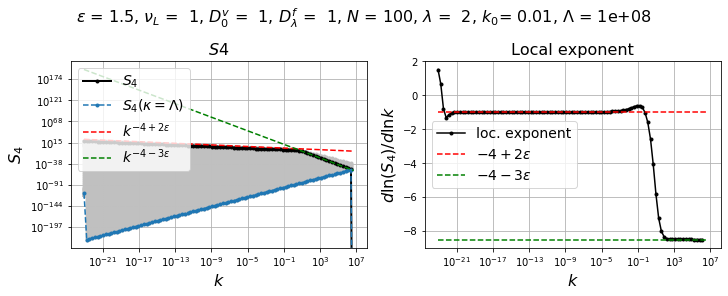

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(10,4))
fig.suptitle(r'$\epsilon$ = %2.1f, $\nu_L$ = %2.2g, $D^v_0$ = %2.2g, $D^f_\lambda$ = %2.2g, $N$ = %2.0i, $\lambda$ = %2.2g, $k_0$= %2.1g, $\Lambda$ = %2.2g' \
             %(eps, nu_L, D0, D_L, Nshells, lmbda, k0, L), fontsize=16)
for m in range(Nshells) :
    ax[0].plot(np.full_like(S4_evolve[m,:], k[m]), S4_evolve[m,:], '.--', color='silver')
ax[0].plot(k,S4_evolve[:,-1], 'k.-', lw=2, label=r'$S_4$')
ax[0].plot(k,S4_evolve[:,0], '.--', label=r'$S_4 (\kappa = \Lambda$)')
ax[0].plot(k,10e-1*k**(-4+2*eps), '--',label=r'$k^{-4+2\epsilon}$', color='red')
#ax[0].plot(k,10e-3*k**(-2), '--',label=r'$k^{-2}$')
ax[0].plot(k,10e1*k**(-4-3*eps), '--',label=r'$k^{-4-3\epsilon}$', color='green')
ax[0].legend()
ax[0].set(title=r'$S4$', xscale='log', yscale='log', xlabel=r'$k$', ylabel=r'$S_4$'); ax[0].grid(True)

slope = np.gradient(np.log(np.abs(S4_evolve[:,-1])), np.log(k))
ax[1].plot(k, slope, 'k.-', label='loc. exponent')
ax[1].plot(k, np.full_like(k, -4+2*eps), '--', label=r'$-4+2\epsilon$', color='red')
ax[1].plot(k, np.full_like(k, -4-3*eps), '--', label=r'$-4-3\epsilon$', color='green')
ax[1].set(title='Local exponent' ,xscale='log', yscale='linear', xlabel=r'$k$', ylabel=r'$d \ln(S_4)/d \ln k$'); ax[1].grid(True)
#ax[1].set(ylim=[-4,1])
ax[1].legend()

# pp = PdfPages('Images/Scalar/shell_S2_inertial_exponent_eps20.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()

plt.show()

# Regulators check

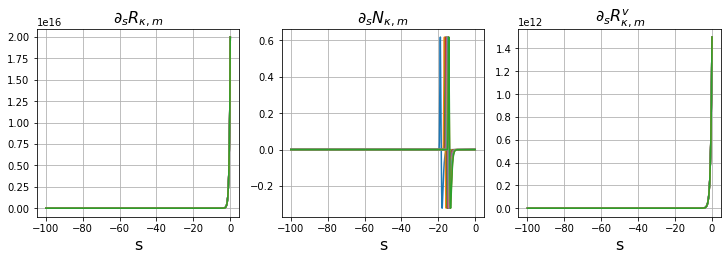

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(10,3.5))
x = np.logspace(-8, 8, 50)
for m in np.arange(1,Nshells,8) :
    ax[0].plot(s, [dsR(m, L*np.exp(val)) for val in s], '-')
    ax[1].plot(s, [dsN(m, L*np.exp(val)) for val in s], '-')
    ax[2].plot(s, [dsRv(m, L*np.exp(val)) for val in s], '-')
for axis in ax : axis.set(xlabel='s'), axis.grid()
ax[0].set(title=r'$\partial_s R_{\kappa,m}$', yscale='linear')
ax[1].set(title=r'$\partial_s N_{\kappa,m}$', yscale='linear')
ax[2].set(title=r'$\partial_s R^v_{\kappa,m}$', yscale='linear')
plt.show()

# Dependennce on $\varepsilon$

In [43]:
S2_set = [{'eps' : 0.5},
          {'eps' : 1.0},
          {'eps' : 1.5},
          {'eps' : 2.0}]

In [44]:
S2_evolve[:,-1]

array([7.45241470e+09, 5.94981523e+09, 3.89420687e+09, 2.65076929e+09,
       1.85779957e+09, 1.31154805e+09, 9.27151638e+08, 6.55565536e+08,
       4.63551510e+08, 3.27780174e+08, 2.31775685e+08, 1.63890283e+08,
       1.15888043e+08, 8.19453196e+07, 5.79441767e+07, 4.09727946e+07,
       2.89722054e+07, 2.04864990e+07, 1.44861911e+07, 1.02433263e+07,
       7.24316229e+06, 5.12172113e+06, 3.62163152e+06, 2.56090433e+06,
       1.81085378e+06, 1.28048520e+06, 9.05455595e+05, 6.40267540e+05,
       4.52749465e+05, 3.20152596e+05, 2.26391089e+05, 1.60090509e+05,
       1.13207892e+05, 8.00559823e+04, 5.66132665e+04, 4.00360892e+04,
       2.83136692e+04, 2.00241577e+04, 1.41621459e+04, 1.00166935e+04,
       7.08508230e+03, 5.01183023e+03, 3.54556775e+03, 2.50854474e+03,
       1.77506860e+03, 1.25625743e+03, 8.89258991e+02, 6.29627190e+02,
       4.45931423e+02, 3.15944750e+02, 2.23948485e+02, 1.58826222e+02,
       1.12716064e+02, 8.00575877e+01, 5.69179160e+01, 4.05151606e+01,
      

In [45]:
S2_set[0]['S2'] = np.array([2.20587025e+32, 5.24454454e+31, 1.15469162e+31, 3.54640571e+30,
       1.23126288e+30, 4.34680971e+29, 1.53669485e+29, 5.43301842e+28,
       1.92086439e+28, 6.79129307e+27, 2.40108997e+27, 8.48915832e+26,
       3.00138100e+26, 1.06115297e+26, 3.75176240e+25, 1.32645719e+25,
       4.68977357e+24, 1.65810267e+24, 5.86235477e+23, 2.07268925e+23,
       7.32821277e+22, 2.59098065e+22, 9.16079265e+21, 3.23895880e+21,
       1.14520217e+21, 4.04915470e+20, 1.43170464e+20, 5.06233747e+19,
       1.79002678e+19, 6.32967601e+18, 2.23831079e+18, 7.91554044e+17,
       2.79941615e+17, 9.90120122e+16, 3.50227641e+16, 1.23898441e+16,
       4.38376945e+15, 1.55136163e+15, 5.49140232e+14, 1.94439831e+14,
       6.88735850e+13, 2.44077596e+13, 8.65493596e+12, 3.07133134e+12,
       1.09093484e+12, 3.87956230e+11, 1.38167264e+11, 4.92971731e+10,
       1.76288430e+10, 6.32180665e+09, 2.27483755e+09, 8.22010338e+08,
       2.98538001e+08, 1.09080027e+08, 4.01406782e+07, 1.48941779e+07,
       5.57883367e+06, 2.11173409e+06, 8.08552937e+05, 3.13358630e+05,
       1.22962553e+05, 4.88478267e+04, 1.96331534e+04, 7.97482317e+03,
       3.26845266e+03, 1.34884884e+03, 5.59134875e+02, 2.32149533e+02,
       9.62314718e+01, 3.96815464e+01, 1.62109927e+01, 6.53106944e+00,
       2.58146824e+00, 9.95273298e-01, 3.71899969e-01, 1.33749257e-01,
       4.59560171e-02, 1.49744680e-02, 4.59493839e-03, 1.32006254e-03,
       3.53722497e-04, 8.83370872e-05, 2.06175078e-05, 4.52522094e-06,
       9.42233792e-07, 1.87969273e-07, 3.62738919e-08, 6.82822812e-09,
       1.26224426e-09, 2.30313232e-10, 4.16356644e-11, 7.47752548e-12,
       1.33669587e-12, 2.38167193e-13, 4.23374018e-14, 7.51371105e-15,
       1.33192829e-15, 2.35911903e-16, 4.17512126e-17, 7.38934416e-18])

In [46]:
S2_set[1]['S2'] = np.array([1.38708652e+21, 5.96325909e+20, 2.37742198e+20, 1.11048995e+20,
       5.49354347e+19, 2.74337566e+19, 1.37150948e+19, 6.85745513e+18,
       3.42872281e+18, 1.71436118e+18, 8.57180593e+17, 4.28590306e+17,
       2.14295160e+17, 1.07147585e+17, 5.35737954e+16, 2.67868997e+16,
       1.33934511e+16, 6.69672643e+15, 3.34836379e+15, 1.67418227e+15,
       8.37091380e+14, 4.18545852e+14, 2.09273033e+14, 1.04636587e+14,
       5.23183397e+13, 2.61592004e+13, 1.30796203e+13, 6.53982337e+12,
       3.26992040e+12, 1.63496594e+12, 8.17486746e+11, 4.08745861e+11,
       2.04374569e+11, 1.02188363e+11, 5.10948923e+10, 2.55479141e+10,
       1.27742652e+10, 6.38733553e+09, 3.19380141e+09, 1.59698872e+09,
       7.98552330e+08, 3.99314344e+08, 1.99682318e+08, 9.98577223e+07,
       4.99397715e+07, 2.49770731e+07, 1.24932717e+07, 6.24975582e+06,
       3.12693394e+06, 1.56482211e+06, 7.83304432e+05, 3.92241339e+05,
       1.96509288e+05, 9.85111081e+04, 4.94248923e+04, 2.48243287e+04,
       1.24861436e+04, 6.29203490e+03, 3.17846037e+03, 1.61075551e+03,
       8.19681321e+02, 4.19361552e+02, 2.16029558e+02, 1.12255669e+02,
       5.89646669e+01, 3.13811395e+01, 1.69604097e+01, 9.32648954e+00,
       5.22293739e+00, 2.97634738e+00, 1.72022434e+00, 1.00172235e+00,
       5.81553631e-01, 3.31595583e-01, 1.82048108e-01, 9.38308872e-02,
       4.39916792e-02, 1.80442710e-02, 6.18657428e-03, 1.69754335e-03,
       3.65737982e-04, 6.35436178e-05, 9.47936421e-06, 1.29446919e-06,
       1.68950187e-07, 2.15697703e-08, 2.72445366e-09, 3.42320823e-10,
       4.29003170e-11, 5.36942617e-12, 6.71608616e-13, 8.39779713e-14,
       1.04989272e-14, 1.31247096e-15, 1.64065435e-16, 2.05085897e-17,
       2.56359936e-18, 3.20451523e-19, 4.00565365e-20, 5.00707174e-21])

In [47]:
S2_set[2]['S2'] = np.array([7.45241470e+09, 5.94981523e+09, 3.89420687e+09, 2.65076929e+09,
       1.85779957e+09, 1.31154805e+09, 9.27151638e+08, 6.55565536e+08,
       4.63551510e+08, 3.27780174e+08, 2.31775685e+08, 1.63890283e+08,
       1.15888043e+08, 8.19453196e+07, 5.79441767e+07, 4.09727946e+07,
       2.89722054e+07, 2.04864990e+07, 1.44861911e+07, 1.02433263e+07,
       7.24316229e+06, 5.12172113e+06, 3.62163152e+06, 2.56090433e+06,
       1.81085378e+06, 1.28048520e+06, 9.05455595e+05, 6.40267540e+05,
       4.52749465e+05, 3.20152596e+05, 2.26391089e+05, 1.60090509e+05,
       1.13207892e+05, 8.00559823e+04, 5.66132665e+04, 4.00360892e+04,
       2.83136692e+04, 2.00241577e+04, 1.41621459e+04, 1.00166935e+04,
       7.08508230e+03, 5.01183023e+03, 3.54556775e+03, 2.50854474e+03,
       1.77506860e+03, 1.25625743e+03, 8.89258991e+02, 6.29627190e+02,
       4.45931423e+02, 3.15944750e+02, 2.23948485e+02, 1.58826222e+02,
       1.12716064e+02, 8.00575877e+01, 5.69179160e+01, 4.05151606e+01,
       2.88814254e+01, 2.06244983e+01, 1.47593278e+01, 1.05888471e+01,
       7.61969265e+00, 5.50259927e+00, 3.99024424e+00, 2.90743109e+00,
       2.12999918e+00, 1.56990388e+00, 1.16466005e+00, 8.69871249e-01,
       6.53941014e-01, 4.94328563e-01, 3.74900388e-01, 2.84066318e-01,
       2.13491112e-01, 1.57251551e-01, 1.11361897e-01, 7.35839108e-02,
       4.33088215e-02, 2.10999334e-02, 7.57856840e-03, 1.75440812e-03,
       2.56869673e-04, 2.77664342e-05, 2.62921139e-06, 2.37828283e-07,
       2.11890320e-08, 1.87807489e-09, 1.66162404e-10, 1.46918931e-11,
       1.29875062e-12, 1.14799373e-13, 1.01470817e-14, 8.96888617e-16,
       7.92746540e-17, 7.00696040e-18, 6.19333799e-19, 5.47418958e-20,
       4.83854586e-21, 4.27671078e-22, 3.78011400e-23, 3.34118000e-24])

In [48]:
S2_set[3]['S2'] = np.array([1.41332852e-01, 2.38029022e-01, 2.68013503e-01, 2.73582973e-01,
       2.74059951e-01, 2.73648605e-01, 2.73074363e-01, 2.72458634e-01,
       2.71822273e-01, 2.71168772e-01, 2.70498410e-01, 2.69810808e-01,
       2.69105426e-01, 2.68381664e-01, 2.67638888e-01, 2.66876434e-01,
       2.66093604e-01, 2.65289668e-01, 2.64463859e-01, 2.63615373e-01,
       2.62743365e-01, 2.61846948e-01, 2.60925189e-01, 2.59977103e-01,
       2.59001657e-01, 2.57997757e-01, 2.56964253e-01, 2.55899928e-01,
       2.54803493e-01, 2.53673588e-01, 2.52508769e-01, 2.51307505e-01,
       2.50068170e-01, 2.48789036e-01, 2.47468263e-01, 2.46103890e-01,
       2.44693822e-01, 2.43235822e-01, 2.41727494e-01, 2.40166268e-01,
       2.38549386e-01, 2.36873878e-01, 2.35136545e-01, 2.33333929e-01,
       2.31462291e-01, 2.29517571e-01, 2.27495360e-01, 2.25390850e-01,
       2.23198786e-01, 2.20913413e-01, 2.18528404e-01, 2.16036781e-01,
       2.13430827e-01, 2.10701971e-01, 2.07840657e-01, 2.04836185e-01,
       2.01676519e-01, 1.98348050e-01, 1.94835306e-01, 1.91120590e-01,
       1.87183529e-01, 1.83000489e-01, 1.78543843e-01, 1.73780992e-01,
       1.68673097e-01, 1.63173356e-01, 1.57224664e-01, 1.50756361e-01,
       1.43679643e-01, 1.35881001e-01, 1.27212837e-01, 1.17480477e-01,
       1.06426373e-01, 9.37197227e-02, 7.89849278e-02, 6.19667947e-02,
       4.30153475e-02, 2.39388961e-02, 8.68371392e-03, 1.55410765e-03,
       1.44999165e-04, 1.00545129e-05, 6.43732355e-07, 4.04671538e-08,
       2.53282276e-09, 1.58357954e-10, 9.89825494e-12, 6.18654726e-13,
       3.86661359e-14, 2.41663686e-15, 1.51039856e-16, 9.43999184e-18,
       5.89999503e-19, 3.68749691e-20, 2.30468557e-21, 1.44042848e-22,
       9.00267803e-24, 5.62667377e-25, 3.51667110e-26, 2.19791940e-27])

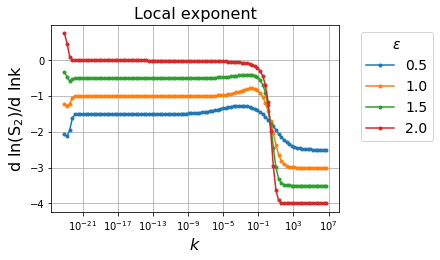

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(6,3.5))

for case in S2_set :
    ax.plot(k, np.gradient(np.log(np.abs(case['S2'])), np.log(k)), '.-', label=case['eps'])

ax.set(xlabel=r'$k$', ylabel=r'$\rm{d}~\ln(S_2)/\rm{d}~\ln k$', yscale='linear', xscale='log', title='Local exponent'); ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$\varepsilon$', title_fontsize=14)
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these_overleaf/60ed6b1cd4de842e8afa5cb1/Figures/S2_var_eps.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()